<h1 align=center><font size = 5>KLASIFIKASI CITRA DERMATOSKOPIK PENYAKIT KANKER KULIT MENGGUNAKAN CONVOLUTIONAL NEURAL NETWORK</font></h1>
<h3 align=center><font size = 3>Huzaifi Hafizhahullah</font></h3>
<h3 align=center><font size = 3>1306619019</font></h3>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "drive/MyDrive/Eksperimen Fisika/data/data.zip"  -d data

In [2]:
import os
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

from PIL import Image
from glob import glob

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from IPython.display import display

# Import Data

In [5]:
data_directory = os.path.join("./", "data/")
os.listdir(data_directory)
data = pd.read_csv(os.path.join(data_directory, 'HAM10000_metadata.csv'))

In [6]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


# Pelabelan

In [7]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(data_directory, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [8]:
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

In [9]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions (bkl),./data/HAM10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions (bkl),./data/HAM10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions (bkl),./data/HAM10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions (bkl),./data/HAM10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions (bkl),./data/ham10000_images_part_2/ISIC_0031633.jpg


In [10]:
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))

In [11]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions (bkl),./data/HAM10000_images_part_1/ISIC_0027419.jpg,"[[[192, 153, 193], [195, 155, 192], [197, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions (bkl),./data/HAM10000_images_part_1/ISIC_0025030.jpg,"[[[27, 16, 32], [69, 49, 76], [122, 93, 126], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions (bkl),./data/HAM10000_images_part_1/ISIC_0026769.jpg,"[[[192, 138, 153], [200, 144, 162], [202, 142,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions (bkl),./data/HAM10000_images_part_1/ISIC_0025661.jpg,"[[[40, 21, 31], [95, 61, 73], [143, 102, 118],..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions (bkl),./data/ham10000_images_part_2/ISIC_0031633.jpg,"[[[159, 114, 140], [194, 144, 173], [215, 162,..."


# Menampilkan contoh-contoh citra berdasarkan labelnya

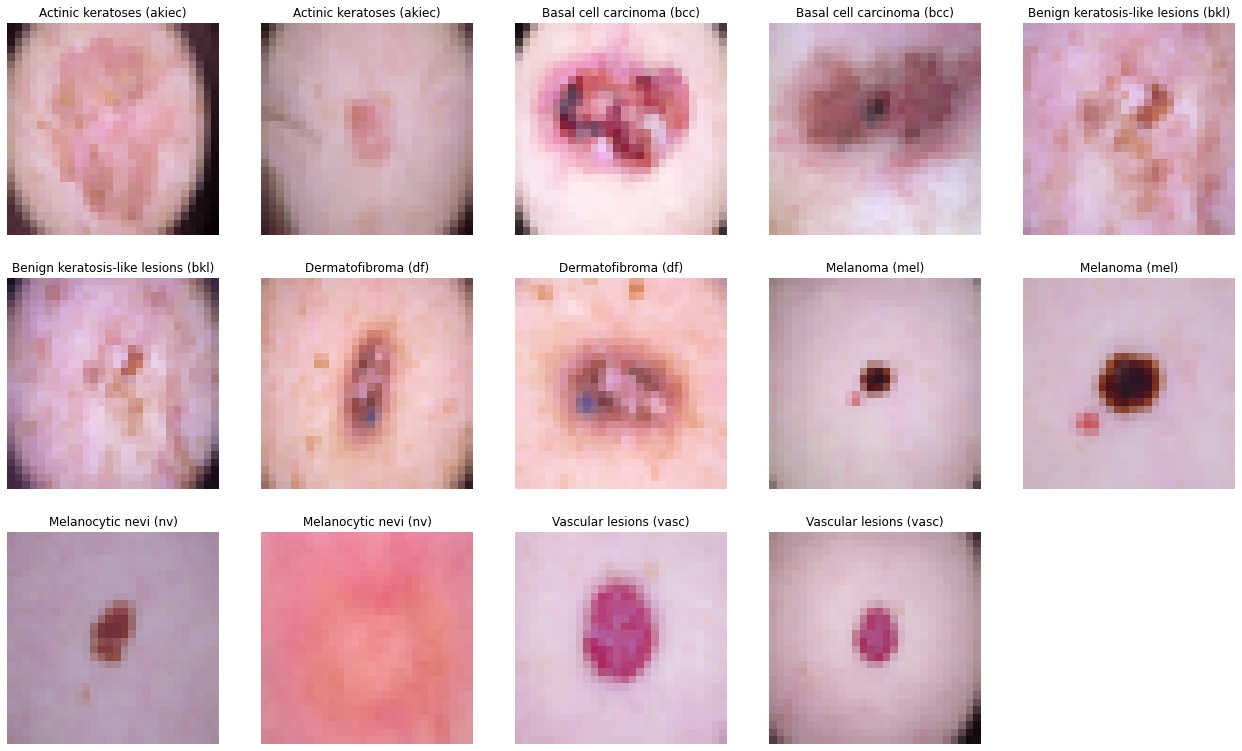

In [12]:
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show()

# Melakukan Image Augmentation

In [13]:
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
data['age'] = data['age'].astype('int32')
data['label'] = data['dx'].map(reverse_label_mapping.get)

In [14]:
index1 = data[data['label'] == 1].index.values
index2 = data[data['label'] == 2].index.values
index3 = data[data['label'] == 3].index.values
index4 = data[data['label'] == 4].index.values
index5 = data[data['label'] == 5].index.values
index6 = data[data['label'] == 6].index.values

df_index1 = data.iloc[int(min(index1)):int(max(index1)+1)]
df_index2 = data.iloc[int(min(index2)):int(max(index2)+1)]
df_index3 = data.iloc[int(min(index3)):int(max(index3)+1)]
df_index4 = data.iloc[int(min(index4)):int(max(index4)+1)]
df_index5 = data.iloc[int(min(index5)):int(max(index5)+1)]
df_index6 = data.iloc[int(min(index6)):int(max(index6)+1)]

df_index1 = df_index1.append([df_index1]*4, ignore_index = True)
df_index2 = df_index2.append([df_index2]*4, ignore_index = True)
df_index3 = df_index3.append([df_index3]*11, ignore_index = True)
df_index4 = df_index4.append([df_index4]*17, ignore_index = True)
df_index5 = df_index5.append([df_index5]*45, ignore_index = True)
df_index6 = df_index6.append([df_index6]*52, ignore_index = True)

frames = [data, df_index1, df_index2, df_index3, df_index4, df_index5, df_index6]
final_data = pd.concat(frames)

In [15]:
final_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),./data/HAM10000_images_part_1/ISIC_0027419.jpg,"[[[192, 153, 193], [195, 155, 192], [197, 154,...",2
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),./data/HAM10000_images_part_1/ISIC_0025030.jpg,"[[[27, 16, 32], [69, 49, 76], [122, 93, 126], ...",2
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),./data/HAM10000_images_part_1/ISIC_0026769.jpg,"[[[192, 138, 153], [200, 144, 162], [202, 142,...",2
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),./data/HAM10000_images_part_1/ISIC_0025661.jpg,"[[[40, 21, 31], [95, 61, 73], [143, 102, 118],...",2
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,Benign keratosis-like lesions (bkl),./data/ham10000_images_part_2/ISIC_0031633.jpg,"[[[159, 114, 140], [194, 144, 173], [215, 162,...",2


In [16]:
print(f"Jumlah gambar sebelum augmentasi: {data.shape[0]}")
print(f"Jumlah gambar setelah augmentasi: {final_data.shape[0]}")

Jumlah gambar sebelum augmentasi: 10015
Jumlah gambar setelah augmentasi: 126876


# Dataset Splitting

In [17]:
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(126876, 28, 28, 3)
(126876, 1)


In [18]:
# Membuat Fungsi untuk dataset train test split
def prepare_for_train_test(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test

# Membuat Fungsi untuk menguji model

In [19]:
# membuat fungsi untuk plotting hasil akursai dan loss terhadap epoch

def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'], 
            name='Training Accuracy'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'], 
            name='Validation Accuracy'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'], 
            name='Training Loss'), 
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'], 
            name='Validation Loss'), 
        row=1, col=2)
    fig['layout']['xaxis']['title']='EPOCH'
    fig['layout']['xaxis2']['title']='EPOCH'
    fig['layout']['yaxis']['title']='Akurasi'
    fig['layout']['yaxis2']['title']='Loss'
    
    fig.show()


# def plot_model_training_curve(history):
#     acc = history.history['accuracy']
#     val_acc = history.history['val_accuracy']
#     loss =  history.history['loss']
#     val_loss =  history.history['val_loss']
    
#     epochs = range(len(acc))
    
#     plt.figure(figsize=(15,5))
#     plt.subplot(121)
#     plt.plot(epochs, acc, 'r', label='Training accuracy')
#     plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
#     plt.title('Training and validation accuracy')
#     plt.xlabel("Epoch")
#     plt.ylabel("Akurasi")
#     plt.legend()
    
#     plt.subplot(122)
#     plt.plot(epochs, loss, 'r', label='Training Loss')
#     plt.plot(epochs, val_loss, 'b', label='Validation Loss')
#     plt.title('Training and validation loss')
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.legend()
#     plt.show()

In [20]:
# Fungsi untuk menampilkan evaluasi model
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    # if normalize:
    #     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #     print("Normalized confusion matrix")
    # else:
    #     print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [39]:
# Fungsi untuk menguji model
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)
    print("Test Accuracy: {:.3f}% \n".format(model_acc[1] * 100))
    print("Test Loss: {:.3f} \n".format(model_acc[0]))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    # print(clr)
    cm = confusion_matrix(Y_test, y_pred)
    plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show()
    return y_pred

# Membuat fungsi model arsitektur convolutional neural network

In [22]:
def model_1():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;

In [23]:
def model_2():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))
    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;

In [24]:
def model_3():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;

In [41]:
def model_4():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
  
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;

In [42]:
def model_5():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;

In [43]:
def model_6():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;

In [44]:
def model_7():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;

In [45]:
def model_8():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;

In [46]:
def model_9():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;

In [47]:
def model_10():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;

In [51]:
def model_11():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;

In [52]:
def model_12():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;

In [29]:
# Membuat fungsi untuk proses pelatihan data
def train_model(model, X_train, Y_train, EPOCHS=5):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                           mode='auto', restore_best_weights=True)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')
    
    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history

# Train Test Data Splitting

In [26]:
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)

# Percobaan 1

In [27]:
model1 = model_1()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 16)                50192     
                                                                 
 dense_1 (Dense)             (None, 7)                 119       
                                                                 
Total params: 50,759
Trainable params: 50,759
Non-trainable params: 0
____________________________________________________

In [30]:
model1_history = train_model(model1, X_train_aug, Y_train_aug, EPOCHS=50)

Epoch 1/50
1269/1269 [==============================] - 15s 4ms/step - loss: 1.2478 - accuracy: 0.6041 - val_loss: 1.0660 - val_accuracy: 0.6215 - lr: 0.0010
Epoch 2/50
1269/1269 [==============================] - 4s 3ms/step - loss: 1.0184 - accuracy: 0.6300 - val_loss: 0.9947 - val_accuracy: 0.6326 - lr: 0.0010
Epoch 3/50
1269/1269 [==============================] - 6s 5ms/step - loss: 0.9453 - accuracy: 0.6633 - val_loss: 0.8579 - val_accuracy: 0.6856 - lr: 0.0010
Epoch 4/50
1269/1269 [==============================] - 5s 4ms/step - loss: 0.8219 - accuracy: 0.6901 - val_loss: 0.8299 - val_accuracy: 0.6909 - lr: 0.0010
Epoch 5/50
1269/1269 [==============================] - 4s 3ms/step - loss: 0.7617 - accuracy: 0.7012 - val_loss: 0.7368 - val_accuracy: 0.7067 - lr: 0.0010
Epoch 6/50
1269/1269 [==============================] - 4s 3ms/step - loss: 0.7192 - accuracy: 0.7116 - val_loss: 0.8104 - val_accuracy: 0.6867 - lr: 0.0010
Epoch 7/50
1269/1269 [==============================] - 4

In [32]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pydot
plot_model_training_curve(model1_history)

Test Accuracy: 91.492% 

Test Loss: 0.228 



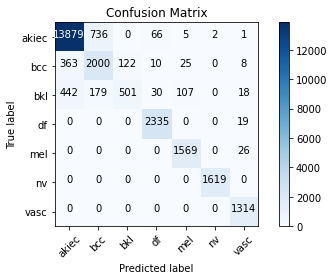

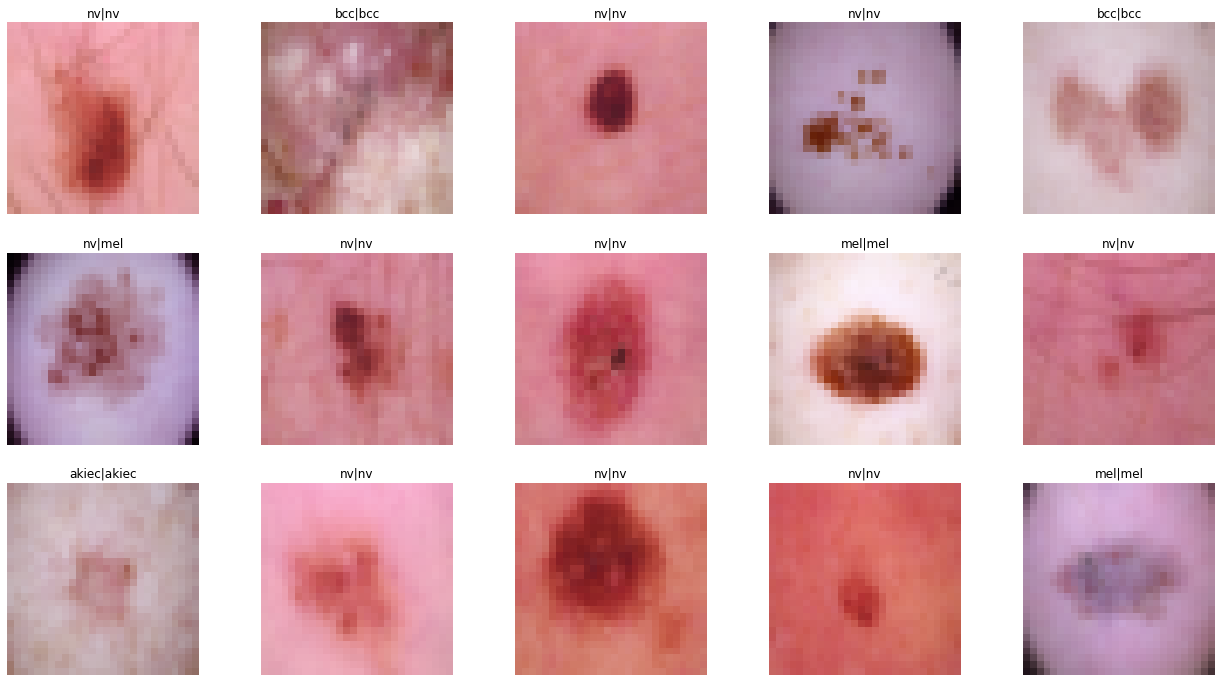

In [40]:
y_pred_1 = test_model(model1, X_test_aug, Y_test_aug)

# Percobaan 2

In [53]:
tf.keras.backend.clear_session()

In [54]:
model2 = model_2()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 16)                2

In [55]:
model2_history = train_model(model2, X_train_aug, Y_train_aug, EPOCHS=50)

Epoch 1/50
1269/1269 [==============================] - 5s 4ms/step - loss: 1.9946 - accuracy: 0.5713 - val_loss: 1.4550 - val_accuracy: 0.5762 - lr: 0.0010
Epoch 2/50
1269/1269 [==============================] - 5s 4ms/step - loss: 1.4272 - accuracy: 0.5799 - val_loss: 1.4271 - val_accuracy: 0.5762 - lr: 0.0010
Epoch 3/50
1269/1269 [==============================] - 5s 4ms/step - loss: 1.4206 - accuracy: 0.5799 - val_loss: 1.4269 - val_accuracy: 0.5762 - lr: 0.0010
Epoch 4/50
1269/1269 [==============================] - 6s 5ms/step - loss: 1.4206 - accuracy: 0.5799 - val_loss: 1.4269 - val_accuracy: 0.5762 - lr: 0.0010
Epoch 5/50
1269/1269 [==============================] - 7s 5ms/step - loss: 1.4206 - accuracy: 0.5799 - val_loss: 1.4269 - val_accuracy: 0.5762 - lr: 0.0010
Epoch 6/50
1269/1269 [==============================] - 5s 4ms/step - loss: 1.4206 - accuracy: 0.5799 - val_loss: 1.4270 - val_accuracy: 0.5762 - lr: 0.0010
Epoch 7/50
1269/1269 [==============================] - 6s

In [56]:
plot_model_training_curve(model2_history)

Test Accuracy: 57.885% 

Test Loss: 1.420 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



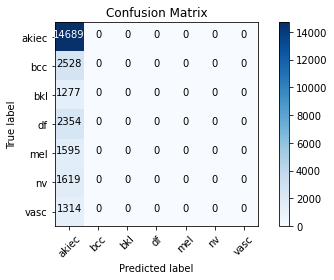

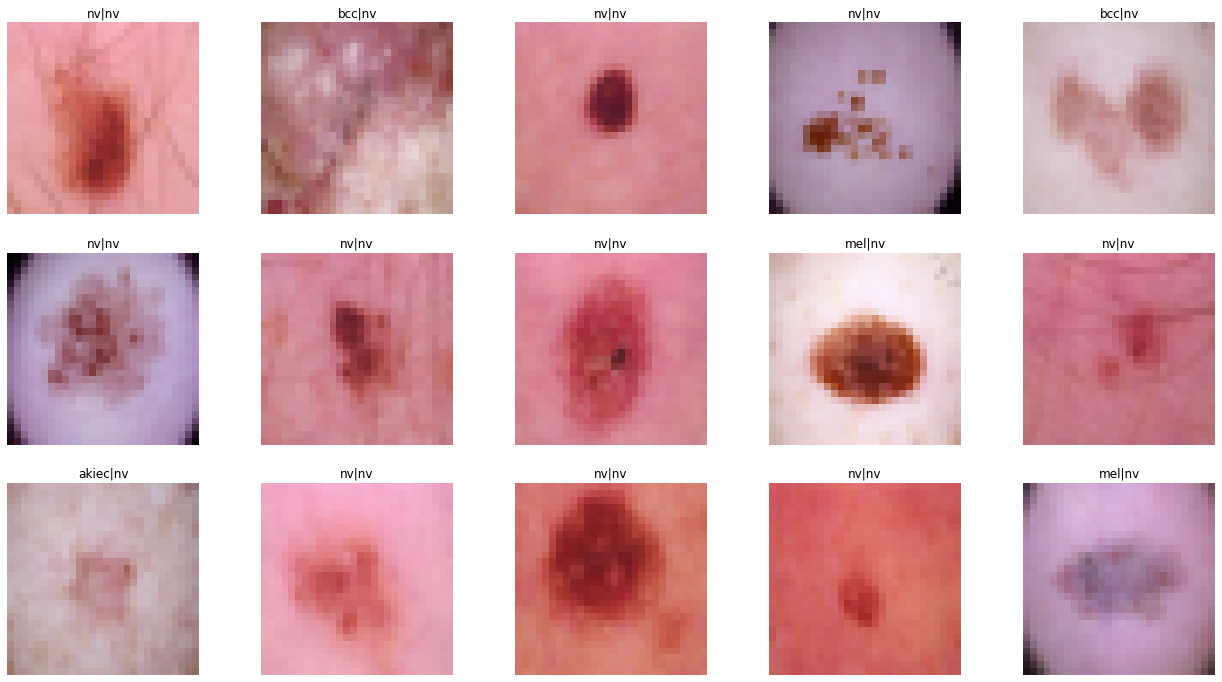

In [57]:
y_pred_2 = test_model(model2, X_test_aug, Y_test_aug)

# Percobaan 3

In [58]:
tf.keras.backend.clear_session()

In [59]:
model3 = model_3()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

In [60]:
model3_history = train_model(model3, X_train_aug, Y_train_aug, EPOCHS=50)

Epoch 1/50
1269/1269 [==============================] - 7s 5ms/step - loss: 1.1460 - accuracy: 0.5977 - val_loss: 1.0037 - val_accuracy: 0.6279 - lr: 0.0010
Epoch 2/50
1269/1269 [==============================] - 6s 4ms/step - loss: 0.9545 - accuracy: 0.6346 - val_loss: 0.9608 - val_accuracy: 0.6381 - lr: 0.0010
Epoch 3/50
1269/1269 [==============================] - 5s 4ms/step - loss: 0.8876 - accuracy: 0.6438 - val_loss: 0.9038 - val_accuracy: 0.6476 - lr: 0.0010
Epoch 4/50
1269/1269 [==============================] - 5s 4ms/step - loss: 0.8424 - accuracy: 0.6652 - val_loss: 0.8442 - val_accuracy: 0.6700 - lr: 0.0010
Epoch 5/50
1269/1269 [==============================] - 6s 5ms/step - loss: 0.8056 - accuracy: 0.6810 - val_loss: 0.7884 - val_accuracy: 0.6862 - lr: 0.0010
Epoch 6/50
1269/1269 [==============================] - 6s 5ms/step - loss: 0.7626 - accuracy: 0.6937 - val_loss: 0.7623 - val_accuracy: 0.6943 - lr: 0.0010
Epoch 7/50
1269/1269 [==============================] - 5s

In [61]:
plot_model_training_curve(model3_history)

Test Accuracy: 99.310% 

Test Loss: 0.031 



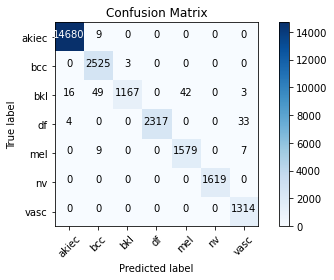

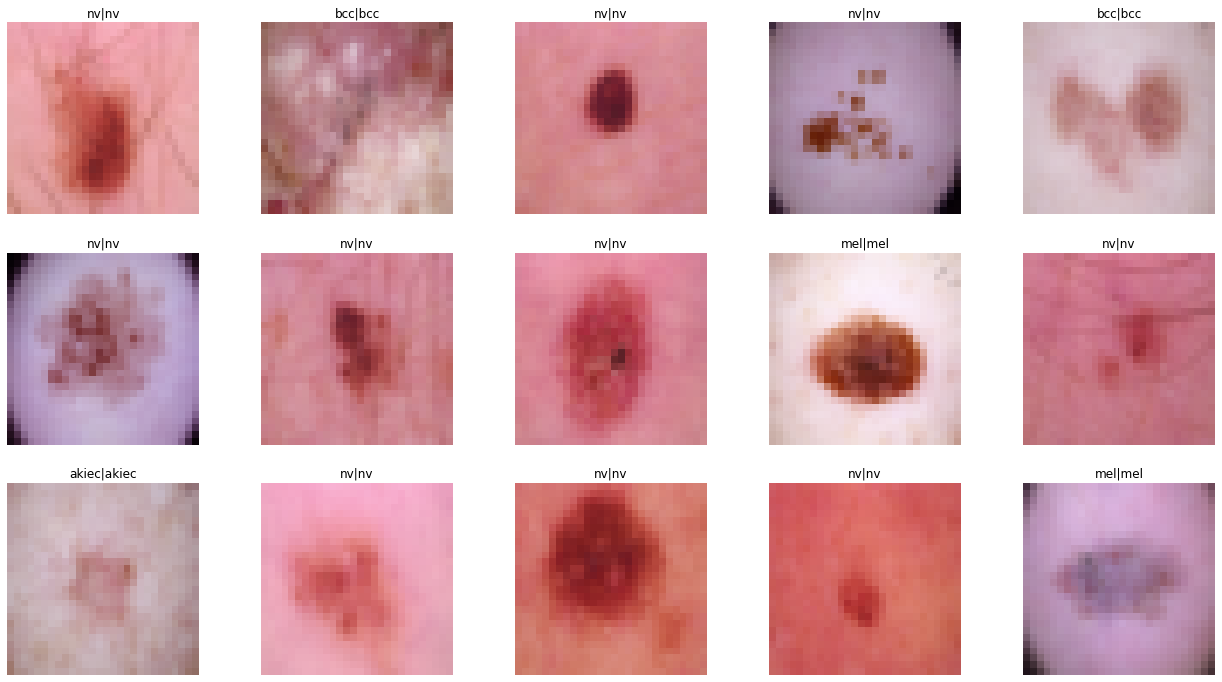

In [62]:
y_pred_3 = test_model(model3, X_test_aug, Y_test_aug)

# Percobaan 4

In [63]:
tf.keras.backend.clear_session()

In [64]:
model4 = model_4()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

In [65]:
model4_history = train_model(model4, X_train_aug, Y_train_aug, EPOCHS=50)

Epoch 1/50
1269/1269 [==============================] - 7s 5ms/step - loss: 1.0434 - accuracy: 0.6548 - val_loss: 0.7653 - val_accuracy: 0.7158 - lr: 0.0010
Epoch 2/50
1269/1269 [==============================] - 6s 4ms/step - loss: 0.5827 - accuracy: 0.7842 - val_loss: 0.4218 - val_accuracy: 0.8435 - lr: 0.0010
Epoch 3/50
1269/1269 [==============================] - 6s 5ms/step - loss: 0.3279 - accuracy: 0.8809 - val_loss: 0.3006 - val_accuracy: 0.8887 - lr: 0.0010
Epoch 4/50
1269/1269 [==============================] - 6s 4ms/step - loss: 0.2359 - accuracy: 0.9148 - val_loss: 0.1873 - val_accuracy: 0.9323 - lr: 0.0010
Epoch 5/50
1269/1269 [==============================] - 6s 5ms/step - loss: 0.1686 - accuracy: 0.9402 - val_loss: 0.1129 - val_accuracy: 0.9603 - lr: 0.0010
Epoch 6/50
1269/1269 [==============================] - 6s 5ms/step - loss: 0.1290 - accuracy: 0.9545 - val_loss: 0.1206 - val_accuracy: 0.9543 - lr: 0.0010
Epoch 7/50
1269/1269 [==============================] - 6s

In [66]:
plot_model_training_curve(model4_history)

Test Accuracy: 99.972% 

Test Loss: 0.003 



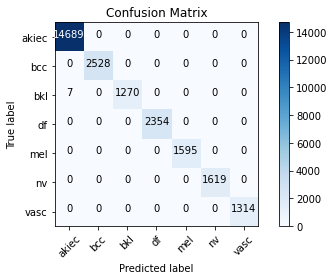

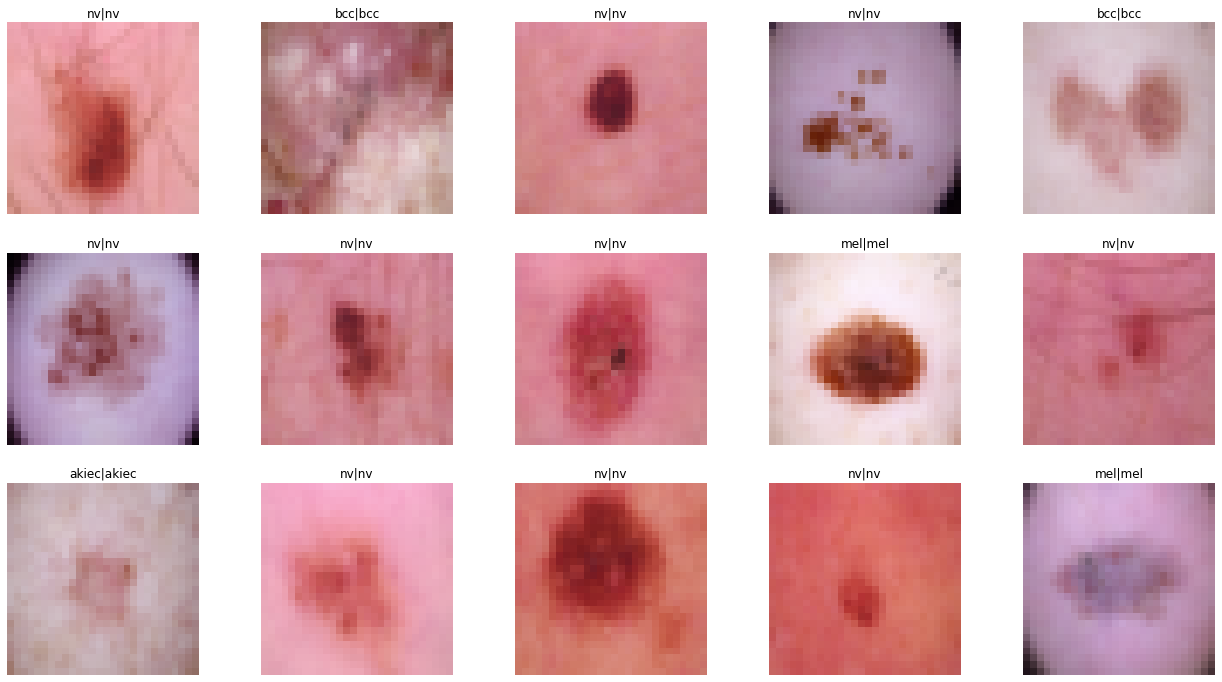

In [67]:
y_pred_4 = test_model(model4, X_test_aug, Y_test_aug)


# Percobaan 5

In [68]:
tf.keras.backend.clear_session()

In [69]:
model5 = model_5()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 32)                100384    
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 7)                 119       
                                                        

In [70]:
model5_history = train_model(model5, X_train_aug, Y_train_aug, EPOCHS=50)

Epoch 1/50
1269/1269 [==============================] - 5s 4ms/step - loss: 1.5773 - accuracy: 0.6249 - val_loss: 0.7908 - val_accuracy: 0.7139 - lr: 0.0010
Epoch 2/50
1269/1269 [==============================] - 5s 4ms/step - loss: 0.6863 - accuracy: 0.7546 - val_loss: 0.5670 - val_accuracy: 0.8008 - lr: 0.0010
Epoch 3/50
1269/1269 [==============================] - 4s 4ms/step - loss: 0.5013 - accuracy: 0.8224 - val_loss: 0.4606 - val_accuracy: 0.8383 - lr: 0.0010
Epoch 4/50
1269/1269 [==============================] - 4s 3ms/step - loss: 0.3848 - accuracy: 0.8641 - val_loss: 0.3185 - val_accuracy: 0.8910 - lr: 0.0010
Epoch 5/50
1269/1269 [==============================] - 5s 4ms/step - loss: 0.3090 - accuracy: 0.8904 - val_loss: 0.3300 - val_accuracy: 0.8843 - lr: 0.0010
Epoch 6/50
1269/1269 [==============================] - 5s 4ms/step - loss: 0.2657 - accuracy: 0.9055 - val_loss: 0.2351 - val_accuracy: 0.9161 - lr: 0.0010
Epoch 7/50
1269/1269 [==============================] - 5s

In [71]:
plot_model_training_curve(model5_history)

Test Accuracy: 99.965% 

Test Loss: 0.005 



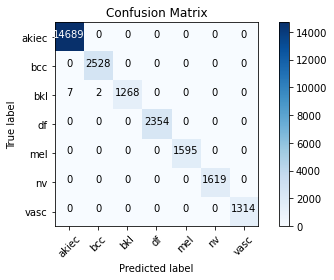

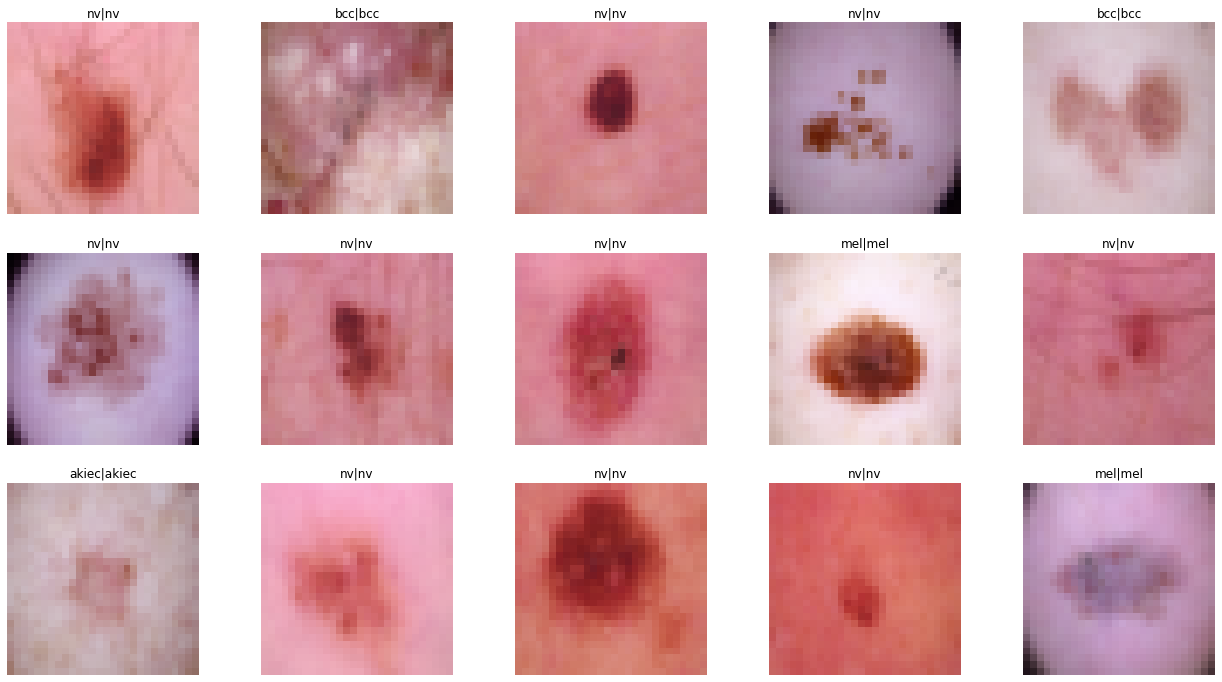

In [72]:
y_pred_5 = test_model(model5, X_test_aug, Y_test_aug)


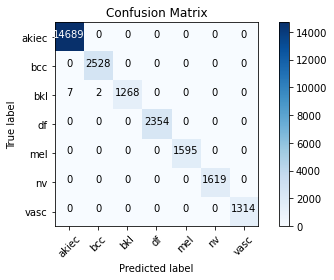

In [73]:
cm = confusion_matrix(Y_test_aug, y_pred_5)
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

# Percobaan 6

In [74]:
tf.keras.backend.clear_session()

In [75]:
model6 = model_6()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 32)                5

In [76]:
model6_history = train_model(model6, X_train_aug, Y_train_aug, EPOCHS=50)

Epoch 1/50
1269/1269 [==============================] - 6s 5ms/step - loss: 1.7844 - accuracy: 0.5728 - val_loss: 1.4371 - val_accuracy: 0.5762 - lr: 0.0010
Epoch 2/50
1269/1269 [==============================] - 6s 5ms/step - loss: 1.4223 - accuracy: 0.5799 - val_loss: 1.4269 - val_accuracy: 0.5762 - lr: 0.0010
Epoch 3/50
1269/1269 [==============================] - 6s 5ms/step - loss: 1.4206 - accuracy: 0.5799 - val_loss: 1.4269 - val_accuracy: 0.5762 - lr: 0.0010
Epoch 4/50
1269/1269 [==============================] - 5s 4ms/step - loss: 1.4206 - accuracy: 0.5799 - val_loss: 1.4272 - val_accuracy: 0.5762 - lr: 0.0010
Epoch 5/50
1269/1269 [==============================] - 5s 4ms/step - loss: 1.4207 - accuracy: 0.5799 - val_loss: 1.4270 - val_accuracy: 0.5762 - lr: 0.0010
Epoch 6/50
1269/1269 [==============================] - 6s 5ms/step - loss: 1.4207 - accuracy: 0.5799 - val_loss: 1.4270 - val_accuracy: 0.5762 - lr: 0.0010
Epoch 7/50
1262/1269 [============================>.] - ET

In [77]:
plot_model_training_curve(model6_history)

Test Accuracy: 57.885% 

Test Loss: 1.420 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



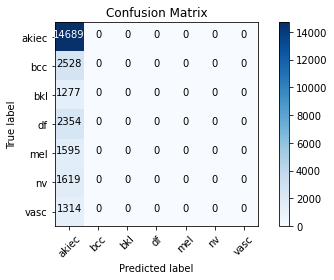

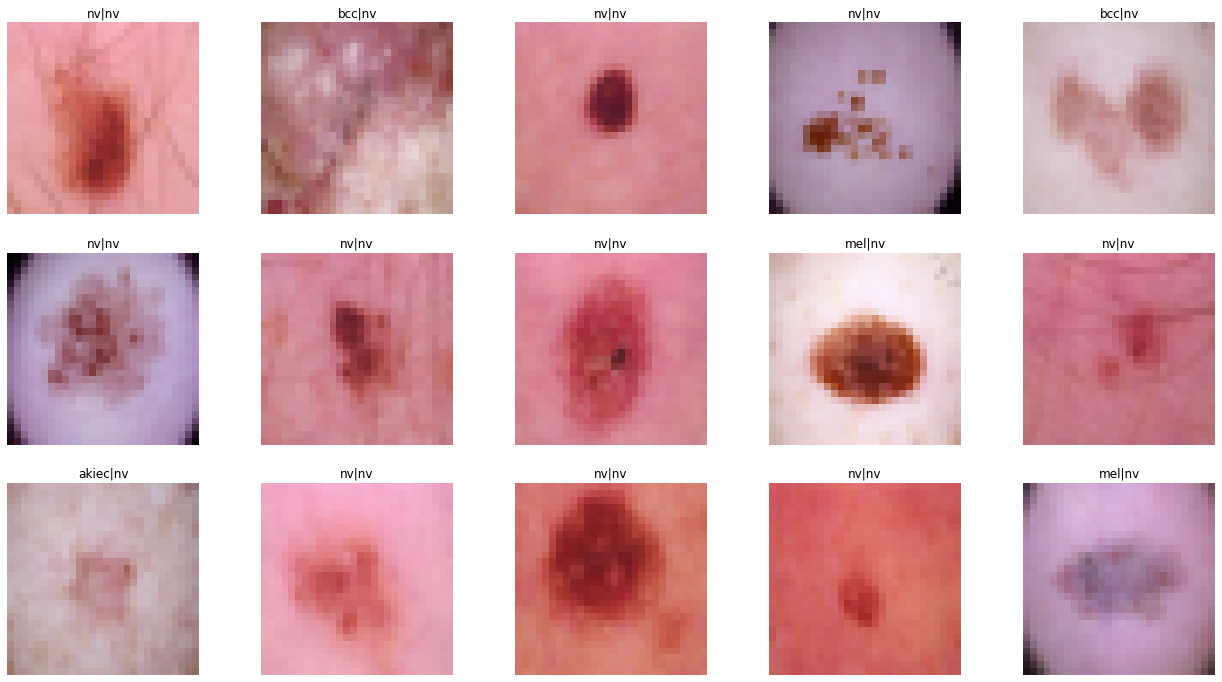

In [109]:
y_pred_6 = test_model(model6, X_test_aug, Y_test_aug)


# Percobaan 7

In [79]:
tf.keras.backend.clear_session()

In [80]:
model7 = model_7()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

In [81]:
model7_history = train_model(model7, X_train_aug, Y_train_aug, EPOCHS=50)

Epoch 1/50
1269/1269 [==============================] - 6s 5ms/step - loss: 0.8737 - accuracy: 0.6969 - val_loss: 0.6168 - val_accuracy: 0.7774 - lr: 0.0010
Epoch 2/50
1269/1269 [==============================] - 6s 5ms/step - loss: 0.5230 - accuracy: 0.8093 - val_loss: 0.3949 - val_accuracy: 0.8594 - lr: 0.0010
Epoch 3/50
1269/1269 [==============================] - 6s 5ms/step - loss: 0.3743 - accuracy: 0.8638 - val_loss: 0.3433 - val_accuracy: 0.8708 - lr: 0.0010
Epoch 4/50
1269/1269 [==============================] - 5s 4ms/step - loss: 0.2770 - accuracy: 0.9004 - val_loss: 0.2313 - val_accuracy: 0.9192 - lr: 0.0010
Epoch 5/50
1269/1269 [==============================] - 6s 5ms/step - loss: 0.2214 - accuracy: 0.9207 - val_loss: 0.2106 - val_accuracy: 0.9264 - lr: 0.0010
Epoch 6/50
1269/1269 [==============================] - 6s 5ms/step - loss: 0.1840 - accuracy: 0.9342 - val_loss: 0.1567 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 7/50
1269/1269 [==============================] - 6s

In [82]:
plot_model_training_curve(model7_history)

Test Accuracy: 99.976% 

Test Loss: 0.003 



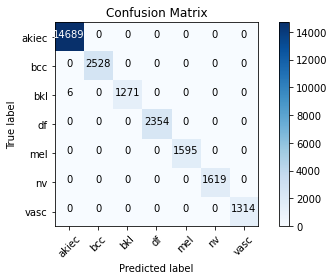

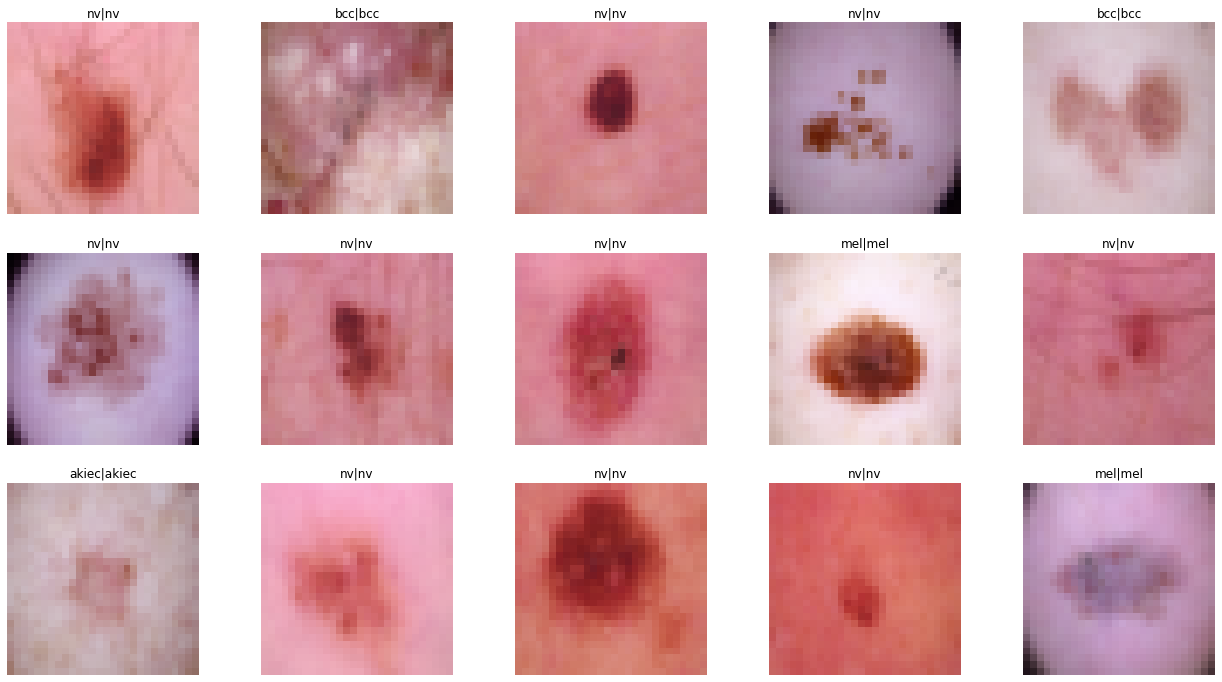

In [83]:
y_pred_7 = test_model(model7, X_test_aug, Y_test_aug)


# Percobaan 8

In [84]:
tf.keras.backend.clear_session()

In [85]:
model8 = model_8()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

In [86]:
model8_history = train_model(model8, X_train_aug, Y_train_aug, EPOCHS=50)

Epoch 1/50
1269/1269 [==============================] - 7s 5ms/step - loss: 0.9736 - accuracy: 0.6692 - val_loss: 0.7212 - val_accuracy: 0.7321 - lr: 0.0010
Epoch 2/50
1269/1269 [==============================] - 6s 5ms/step - loss: 0.6036 - accuracy: 0.7745 - val_loss: 0.5110 - val_accuracy: 0.8129 - lr: 0.0010
Epoch 3/50
1269/1269 [==============================] - 6s 5ms/step - loss: 0.4106 - accuracy: 0.8506 - val_loss: 0.3421 - val_accuracy: 0.8783 - lr: 0.0010
Epoch 4/50
1269/1269 [==============================] - 6s 5ms/step - loss: 0.2626 - accuracy: 0.9074 - val_loss: 0.2335 - val_accuracy: 0.9191 - lr: 0.0010
Epoch 5/50
1269/1269 [==============================] - 6s 5ms/step - loss: 0.1824 - accuracy: 0.9365 - val_loss: 0.1729 - val_accuracy: 0.9402 - lr: 0.0010
Epoch 6/50
1269/1269 [==============================] - 6s 5ms/step - loss: 0.1404 - accuracy: 0.9520 - val_loss: 0.0790 - val_accuracy: 0.9754 - lr: 0.0010
Epoch 7/50
1269/1269 [==============================] - 6s

In [87]:
plot_model_training_curve(model8_history)

Test Accuracy: 99.988% 

Test Loss: 0.001 



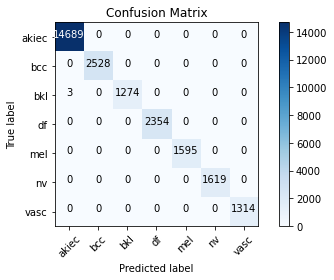

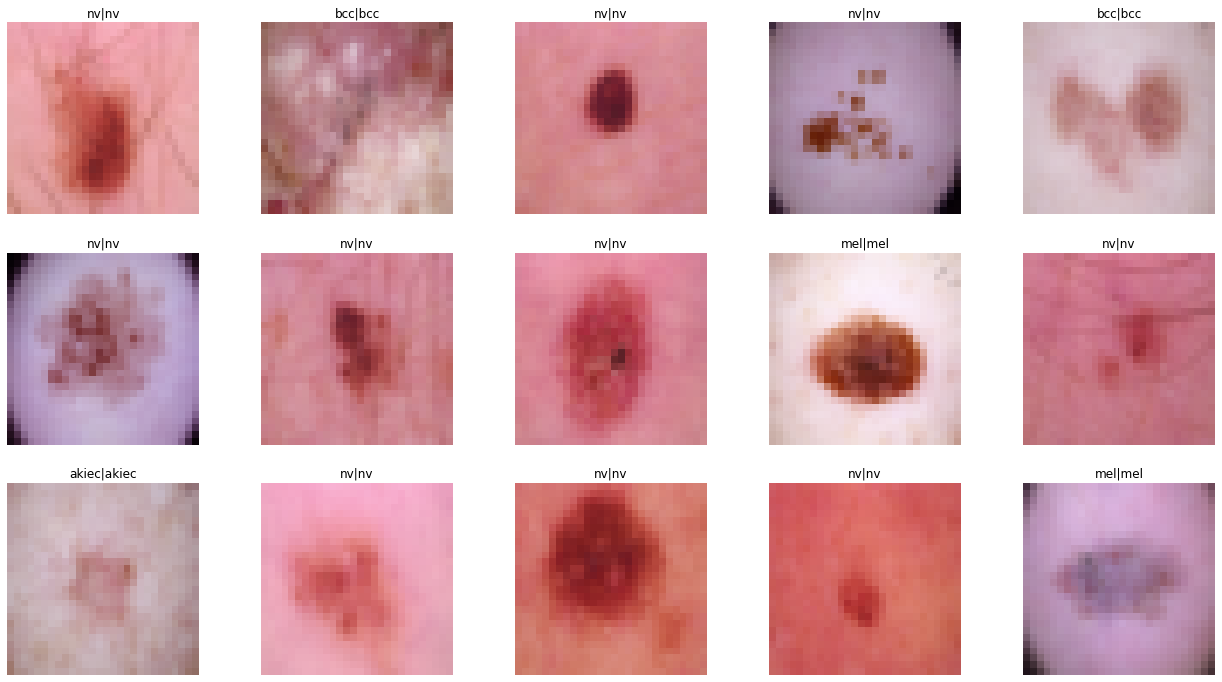

In [88]:
y_pred_8 = test_model(model8, X_test_aug, Y_test_aug)


# Percobaan 9

In [89]:
tf.keras.backend.clear_session()

In [90]:
model9 = model_9()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 64)                200768    
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                        

In [91]:
model9_history = train_model(model9, X_train_aug, Y_train_aug, EPOCHS=50)

Epoch 1/50
1269/1269 [==============================] - 5s 4ms/step - loss: 1.6129 - accuracy: 0.5875 - val_loss: 0.9888 - val_accuracy: 0.6552 - lr: 0.0010
Epoch 2/50
1269/1269 [==============================] - 5s 4ms/step - loss: 0.9020 - accuracy: 0.6726 - val_loss: 0.7829 - val_accuracy: 0.7023 - lr: 0.0010
Epoch 3/50
1269/1269 [==============================] - 5s 4ms/step - loss: 0.7263 - accuracy: 0.7271 - val_loss: 0.6654 - val_accuracy: 0.7503 - lr: 0.0010
Epoch 4/50
1269/1269 [==============================] - 5s 4ms/step - loss: 0.5879 - accuracy: 0.7856 - val_loss: 0.4783 - val_accuracy: 0.8338 - lr: 0.0010
Epoch 5/50
1269/1269 [==============================] - 5s 4ms/step - loss: 0.4342 - accuracy: 0.8432 - val_loss: 0.3990 - val_accuracy: 0.8568 - lr: 0.0010
Epoch 6/50
1269/1269 [==============================] - 5s 4ms/step - loss: 0.3442 - accuracy: 0.8765 - val_loss: 0.2914 - val_accuracy: 0.8955 - lr: 0.0010
Epoch 7/50
1269/1269 [==============================] - 5s

In [92]:
plot_model_training_curve(model9_history)

Test Accuracy: 99.976% 

Test Loss: 0.002 



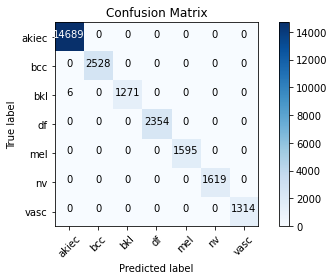

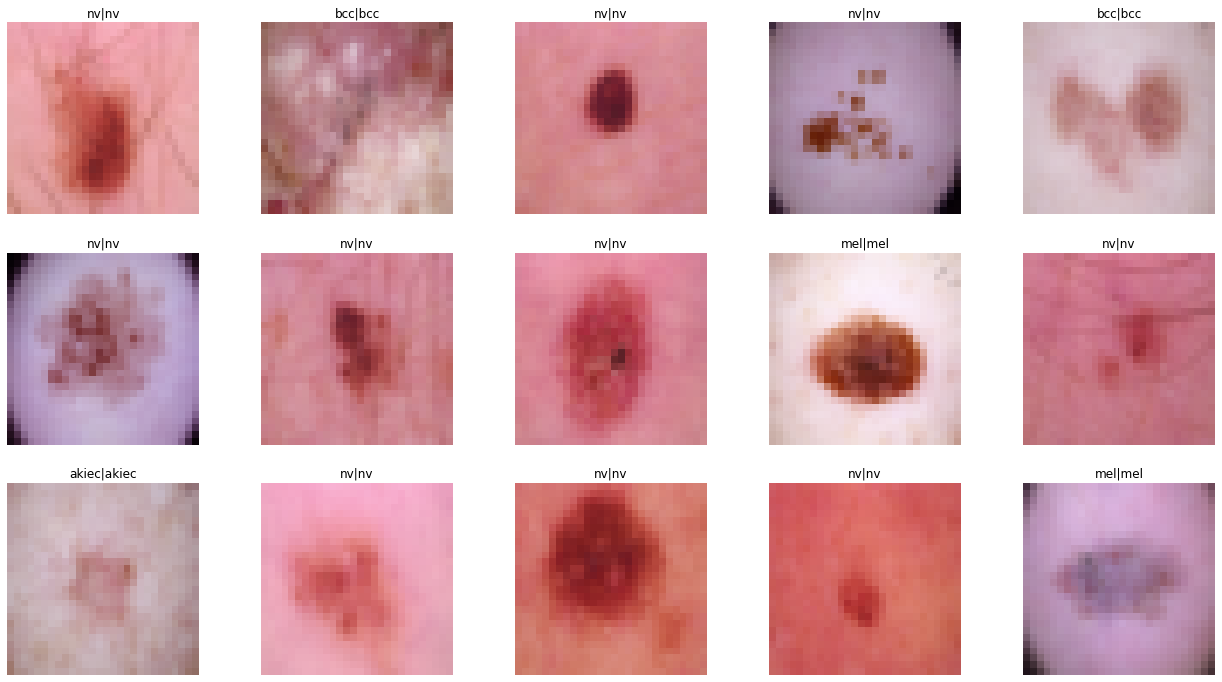

In [93]:
y_pred_9 = test_model(model9, X_test_aug, Y_test_aug)


# Percobaan 10

In [94]:
tf.keras.backend.clear_session()

In [95]:
model10 = model_10()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 64)                1

In [96]:
model10_history = train_model(model10, X_train_aug, Y_train_aug, EPOCHS=50)

Epoch 1/50
1269/1269 [==============================] - 6s 4ms/step - loss: 1.0979 - accuracy: 0.6568 - val_loss: 0.7642 - val_accuracy: 0.7229 - lr: 0.0010
Epoch 2/50
1269/1269 [==============================] - 5s 4ms/step - loss: 0.6707 - accuracy: 0.7554 - val_loss: 0.5790 - val_accuracy: 0.7929 - lr: 0.0010
Epoch 3/50
1269/1269 [==============================] - 5s 4ms/step - loss: 0.5227 - accuracy: 0.8116 - val_loss: 0.4628 - val_accuracy: 0.8331 - lr: 0.0010
Epoch 4/50
1269/1269 [==============================] - 5s 4ms/step - loss: 0.4274 - accuracy: 0.8449 - val_loss: 0.4244 - val_accuracy: 0.8448 - lr: 0.0010
Epoch 5/50
1269/1269 [==============================] - 6s 5ms/step - loss: 0.3562 - accuracy: 0.8718 - val_loss: 0.3144 - val_accuracy: 0.8848 - lr: 0.0010
Epoch 6/50
1269/1269 [==============================] - 5s 4ms/step - loss: 0.2935 - accuracy: 0.8944 - val_loss: 0.2873 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 7/50
1269/1269 [==============================] - 6s

In [97]:
plot_model_training_curve(model10_history)

Test Accuracy: 99.949% 

Test Loss: 0.005 



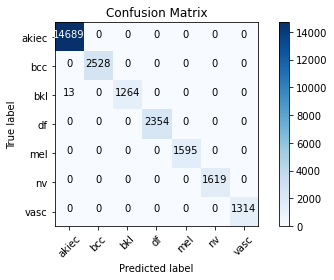

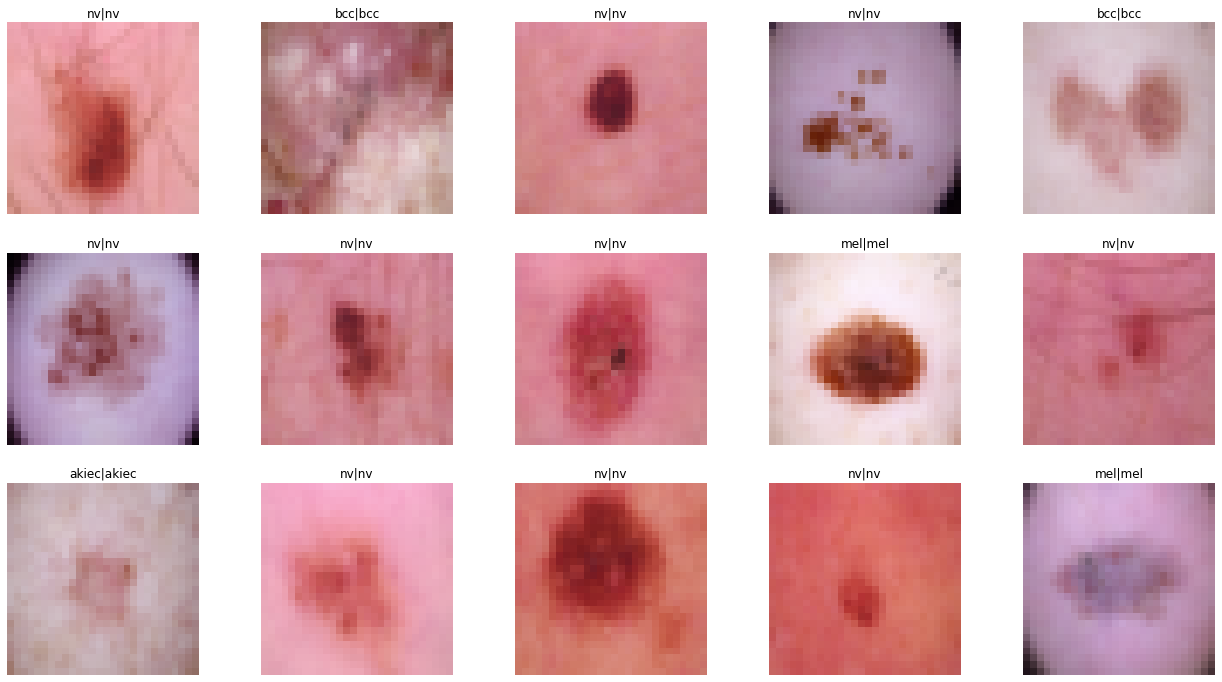

In [98]:
y_pred_10 = test_model(model10, X_test_aug, Y_test_aug)


# Percobaan 11

In [99]:
tf.keras.backend.clear_session()

In [100]:
model11 = model_11()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

In [101]:
model11_history = train_model(model11, X_train_aug, Y_train_aug, EPOCHS=50)

Epoch 1/50
1269/1269 [==============================] - 7s 5ms/step - loss: 1.1154 - accuracy: 0.6211 - val_loss: 0.8633 - val_accuracy: 0.6830 - lr: 0.0010
Epoch 2/50
1269/1269 [==============================] - 6s 5ms/step - loss: 0.7212 - accuracy: 0.7383 - val_loss: 0.5948 - val_accuracy: 0.7821 - lr: 0.0010
Epoch 3/50
1269/1269 [==============================] - 6s 5ms/step - loss: 0.4772 - accuracy: 0.8283 - val_loss: 0.3938 - val_accuracy: 0.8592 - lr: 0.0010
Epoch 4/50
1269/1269 [==============================] - 6s 5ms/step - loss: 0.3318 - accuracy: 0.8815 - val_loss: 0.2928 - val_accuracy: 0.8993 - lr: 0.0010
Epoch 5/50
1269/1269 [==============================] - 6s 5ms/step - loss: 0.2512 - accuracy: 0.9107 - val_loss: 0.2792 - val_accuracy: 0.8982 - lr: 0.0010
Epoch 6/50
1269/1269 [==============================] - 6s 5ms/step - loss: 0.1865 - accuracy: 0.9337 - val_loss: 0.2284 - val_accuracy: 0.9220 - lr: 0.0010
Epoch 7/50
1269/1269 [==============================] - 6s

In [102]:
plot_model_training_curve(model11_history)

Test Accuracy: 99.961% 

Test Loss: 0.003 



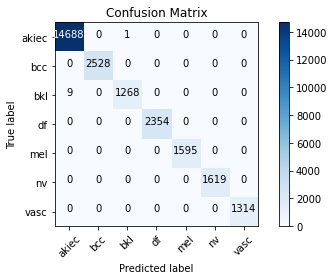

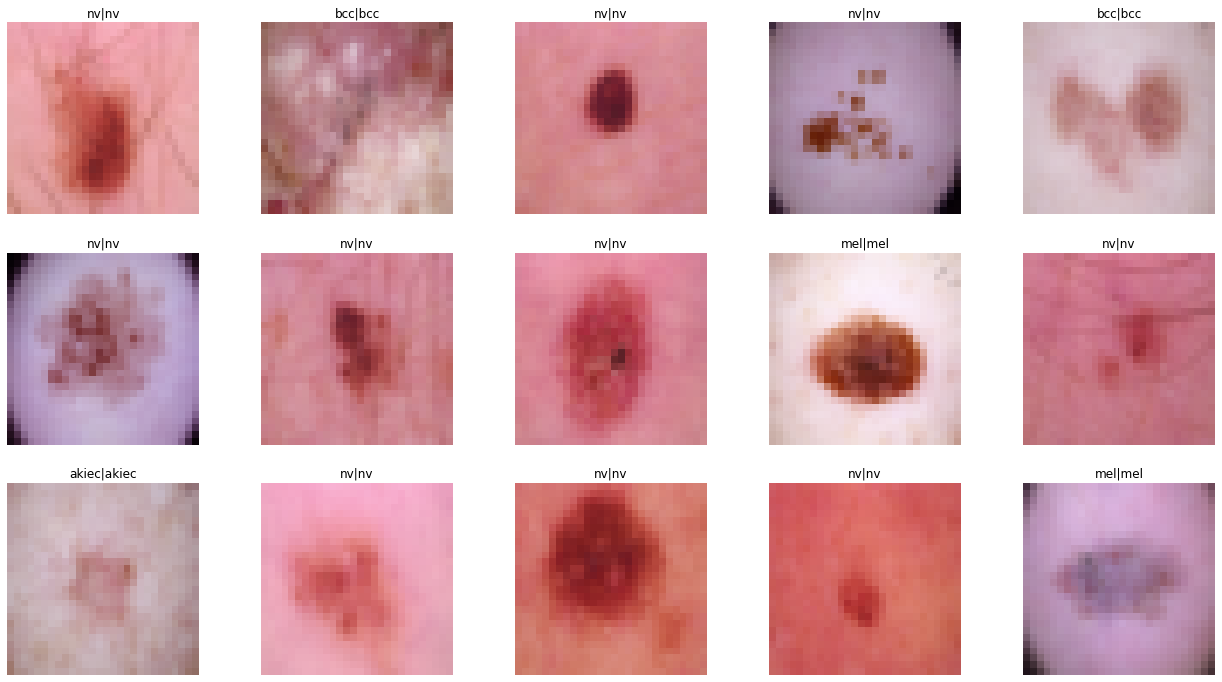

In [103]:
y_pred_11 = test_model(model11, X_test_aug, Y_test_aug)


# Percobaan 12

In [104]:
tf.keras.backend.clear_session()

In [105]:
model12 = model_12()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

In [106]:
model12_history = train_model(model12, X_train_aug, Y_train_aug, EPOCHS=50)

Epoch 1/50
1269/1269 [==============================] - 7s 5ms/step - loss: 0.9315 - accuracy: 0.6789 - val_loss: 0.6526 - val_accuracy: 0.7698 - lr: 0.0010
Epoch 2/50
1269/1269 [==============================] - 7s 5ms/step - loss: 0.5055 - accuracy: 0.8158 - val_loss: 0.4108 - val_accuracy: 0.8525 - lr: 0.0010
Epoch 3/50
1269/1269 [==============================] - 7s 5ms/step - loss: 0.2933 - accuracy: 0.8943 - val_loss: 0.1886 - val_accuracy: 0.9307 - lr: 0.0010
Epoch 4/50
1269/1269 [==============================] - 6s 5ms/step - loss: 0.1867 - accuracy: 0.9346 - val_loss: 0.1876 - val_accuracy: 0.9313 - lr: 0.0010
Epoch 5/50
1269/1269 [==============================] - 7s 5ms/step - loss: 0.1460 - accuracy: 0.9493 - val_loss: 0.1371 - val_accuracy: 0.9530 - lr: 0.0010
Epoch 6/50
1269/1269 [==============================] - 6s 5ms/step - loss: 0.1075 - accuracy: 0.9631 - val_loss: 0.0912 - val_accuracy: 0.9699 - lr: 0.0010
Epoch 7/50
1269/1269 [==============================] - 7s

In [107]:
plot_model_training_curve(model12_history)

Test Accuracy: 99.972% 

Test Loss: 0.003 



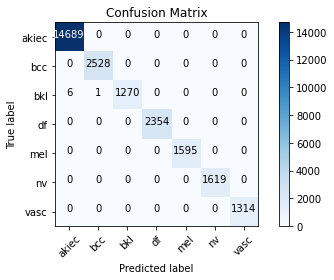

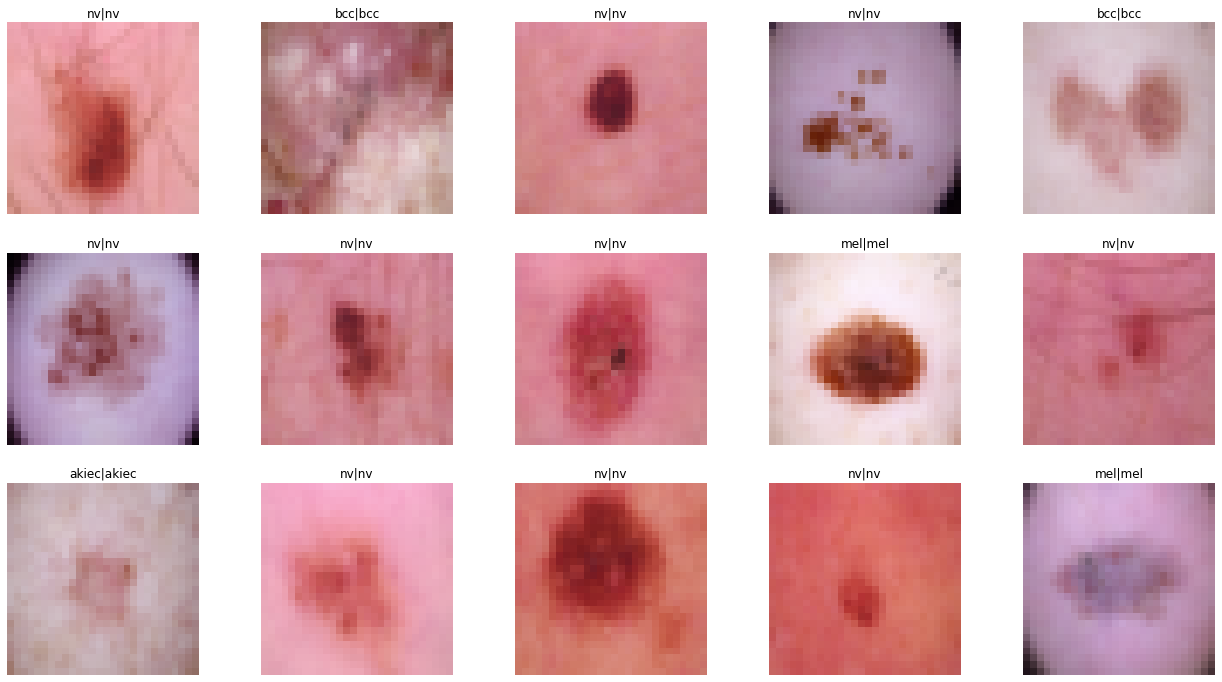

In [108]:
y_pred_12 = test_model(model12, X_test_aug, Y_test_aug)
